In [6]:
import glob
import rasterio
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from common.constants import NODATA_FLOAT32


torch.manual_seed(666)

def get_chip(path):
    return path.split('/')[-1].replace('.tif', '')


class CloudDataset(Dataset):
    def __init__(self, root_dir, sub_dir):
        self.data_dir = f'{root_dir}/{sub_dir}'
                        
        image_paths = glob.glob(f'{self.data_dir}/source/*.tif')        
        label_paths = glob.glob(f'{self.data_dir}/labels/*.tif')
        
        image_paths = sorted(image_paths, key=lambda x: x.split('/')[-1])
        label_paths = sorted(label_paths, key=lambda x: x.split('/')[-1])
        
        assert len(image_paths) == len(label_paths)

        self.image_paths = image_paths
        self.label_paths = label_paths
        
        print(f'{sub_dir}... {len(self.image_paths)} chips')
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
                
        image_path = self.image_paths[index]
        label_path = self.label_paths[index]
        
        image_name = image_path.split('/')[-1]
        label_name = label_path.split('/')[-1]        
        assert image_name == label_name
        
        with rasterio.open(image_path) as src:
            image = src.read(masked=True)
            image = image.filled(-1.0) # fill with -1.0 rather than -9999.0
            image = torch.from_numpy(image)
        with rasterio.open(label_path) as src:
            label = src.read(1)
            label = torch.from_numpy(label).long()     
        
        return image, label

cloud_training_dir = "./data/mergedCloudTrainingData/split"

train_dataset = CloudDataset(root_dir=cloud_training_dir, sub_dir='train')
train_dataloader = DataLoader(train_dataset, batch_size=8, num_workers=0, shuffle=True)

val_dataset = CloudDataset(root_dir=cloud_training_dir, sub_dir='val')
val_dataloader = DataLoader(val_dataset, batch_size=8, num_workers=0, shuffle=True)

test_dataset = CloudDataset(root_dir=cloud_training_dir, sub_dir='test')
test_dataloader = DataLoader(test_dataset, batch_size=8, num_workers=0, shuffle=True)


train... 2867 chips
val... 358 chips
test... 359 chips


## Setup model and loss

In [7]:

ACTIVATION = None
ENCODER = 'resnet18' 
LOSS = 'dice'

model = smp.UnetPlusPlus(
    encoder_name=ENCODER,
    encoder_depth=5, 
    encoder_weights='imagenet', 
    decoder_use_batchnorm=True, 
    decoder_channels=(256, 128, 64, 32, 16), 
    decoder_attention_type=None,
    in_channels=4,
    classes=1,
    activation=ACTIVATION
)


if LOSS == 'dice':
    loss = smp.losses.DiceLoss(mode="binary")
    loss.__name__ = 'Dice_loss'
else:
    raise ValueError("loss not implemented")

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)


## Set up epochs and run training

In [8]:
import datetime

now = datetime.datetime.now()
date_string = now.strftime("%Y%m%d")
model_path =  f'./cloud_detection_model_{ENCODER}_{LOSS}_{date_string}.pth'
print(model_path)


./cloud_detection_model_resnet18_dice_20230327.pth


In [9]:

print(model_path)

metrics = []

train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=loss,
    metrics= metrics,
    optimizer=optimizer,
    verbose=True,
)

val_epoch = smp_utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    verbose=True,
)


NUM_EPOCHS = 4

# 4 epochs, 1561 training chips: 0.06787 dice loss
# 4 epochs, 1657 training chips: 0.08707 dice loss
# 2 epochs, 2483 training chips: 0.1043 dice loss
# 4 epochs, 2867 training chips: 0.1019 dice loss

for i in range(0, NUM_EPOCHS):
    train_logs = train_epoch.run(train_dataloader)
    val_logs = val_epoch.run(val_dataloader)
    torch.save(model, model_path)
    
print('done')

./cloud_detection_model_resnet18_dice_20230327.pth
valid: 100%|██████████| 45/45 [02:03<00:00,  2.75s/it, Dice_loss - 0.08785]
done


In [10]:

test_epoch = smp_utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    verbose=True,
)

test_logs = test_epoch.run(test_dataloader)


valid: 100%|██████████| 45/45 [02:19<00:00,  3.11s/it, Dice_loss - 0.1019] 


## Visualize model outputs

./data/mergedCloudTrainingData/split/test/source/S2A_35MQU_20200323_0_L2A_2904n1452936n122_0_4_90deg.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./data/mergedCloudTrainingData/split/test/source/S2A_35MQU_20200323_0_L2A_2904n1452936n122_1_4_nodata.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./data/mergedCloudTrainingData/split/test/source/S2A_35MQU_20200323_0_L2A_2904n1452936n122_2_1_nodata.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


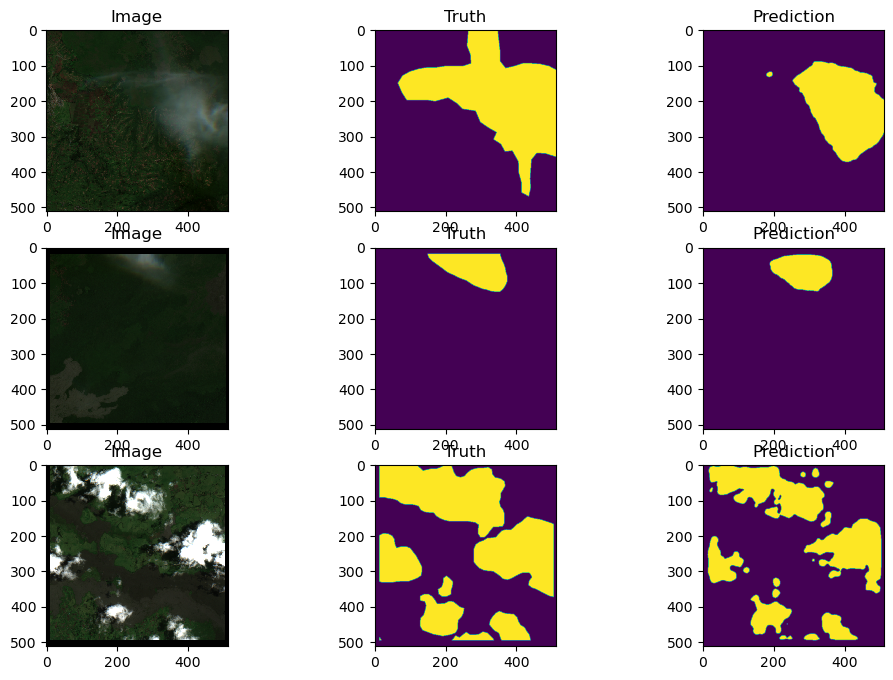

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from common.utilities.visualization import plot_bands


count = 3
offset = 10

fig, rows = plt.subplots(count, 3, figsize=(12, 8))
if rows.ndim == 1:
    rows = np.expand_dims(rows, 0)

    
# model_path = "./best_resnet18_dice_cloud_detection.pth"
best_model = torch.load(model_path)

for i in range(count):
                    
    row = rows[i]    
    image, labels = test_dataset[i+offset]    
    image_path = test_dataset.image_paths[i+offset]
    print(image_path)
        
    image = np.expand_dims(image, 0) 
    image = torch.tensor(image)
    
    prediction = best_model.predict(image)       
    probabilities = torch.sigmoid(prediction).cpu().numpy()
    probabilities = probabilities[0, 0, :, :]
    binary_prediction = (probabilities >= 0.80).astype(bool)
        
    labels = labels.squeeze().numpy()
    labels = np.ma.array(labels, mask=(labels==2))

    image = image.cpu().numpy().squeeze(0)
    plot_bands(image, bands=[2, 1, 0], ax=row[0], transpose=True)
    row[0].set_title('Image')
    
    row[1].imshow(labels, vmin=0, vmax=1)
    row[1].set_title('Truth')
    
    row[2].imshow(binary_prediction, vmin=0, vmax=1)
    row[2].set_title('Prediction')
    

## Deploy model on SageMaker

In [ ]:
%%bash

gzip cloud_detection_model_resnet18_dice_20230228.pth


In [30]:

from common.constants import S3_MODELS_BUCKET
from common.aws.s3 import put_item


model_gzip_path = model_path.replace('.pth', '.tar.gz')
model_name = model_path.split('/')[-1].replace('.pth', '.tar.gz')
object_key = f'cloud-detection/{model_name}'

print(f'saving {model_path} to {S3_MODELS_BUCKET}:{object_key}')

put_item(model_gzip_path, S3_MODELS_BUCKET, object_key)

print('done')

saving ./cloud_detection_model_resnet18_dice_20230228.pth to smartcarte-models:cloud-detection/cloud_detection_model_resnet18_dice_20230228.tar.gz
done


In [31]:
import boto3
import sagemaker
from sagemaker.pytorch import PyTorchModel

model_s3_path = f's3://{S3_MODELS_BUCKET}/{object_key}'

pytorch_model = PyTorchModel(entry_point="./entry-point-cloud-model.py",
                             model_data=model_s3_path,
                             role=sagemaker.get_execution_role(),
                             framework_version='1.8.1',
                             py_version='py3')

predictor = pytorch_model.deploy(endpoint_name="cloud-detection-endpoint",
                                 instance_type='ml.m5.large',
                                 initial_instance_count=1)


-----!

In [33]:
import rasterio

composite_path = "./data/20200101_20200301_south/composite.tif"

with rasterio.open(composite_path) as src:
    data = src.read()
   


"""
LOTS NOT WORKING. DONE IN A RUSH. FIX THIS AFTER FIXING ALIGNMENT ISSUE

SSLError: SSL validation failed for 
https://runtime.sagemaker.us-west-2.amazonaws.com/endpoints/cloud-detection-endpoint/invocations 
EOF occurred in violation of protocol (_ssl.c:2396)
"""


results = predictor.predict(data)
print(results.shape)
print(results)


SSLError: SSL validation failed for https://runtime.sagemaker.us-west-2.amazonaws.com/endpoints/cloud-detection-endpoint/invocations EOF occurred in violation of protocol (_ssl.c:2396)